In [1]:
import logging
import sys
sys.path.append("../../src")
from solver import SolverWithDrop, _OPT_OPTIONS
import numpy as np

format = '%(filename)s:%(lineno)d [%(levelname)s] %(message)s'
logging.basicConfig(
    level=logging.getLevelName(logging.INFO), format=format)

In [2]:
_OPT_OPTIONS["cobyla"] = {'rhobeg': 2.0}
_OPT_OPTIONS["slsqp"] = {'eps': 2.0}

processing_time = 180
target_latency = 180 * 4

input_rates = np.array([
    [843, 862,  883,  960, 917, 908, 1058],
    [709, 637,  607,  641, 597, 710,  721],
    [881, 871,  912,  929, 878, 977,  835],
    [676, 713, 1113,  690, 699, 700,  767],
    [1441, 1453, 1424, 1439, 1470, 1429, 1450],
    [664, 606,  571,  603, 603, 671,  686],
    [467, 486,  504,  525, 481, 527,  477],
    [1148, 1149, 1020, 1096, 1106, 1064, 1011],
    [1077, 1090,  982,  859, 677, 577,  515],
    [396, 354,  444,  397, 369, 465,  458],
]) / 60

num_replicas = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
resource_limit = 40

In [ ]:
import time
from collections import defaultdict

def solve(util_type, method, mdc_percentile=0, max_rho = 0.95):
    solver = SolverWithDrop(
        resource_limit,
        min_max=False,
        adjust=False,
        method=method,
        mdc_percentile=mdc_percentile,
        upscale_overhead=1,
        max_rho=max_rho,
        util_type=util_type 
        # drop_integrality=True,
        # drop_weight=0.0,
        # linear_penalty=True,
    )
    for i, (input_rate, num_replica) in enumerate(zip(input_rates, num_replicas)):
        solver.add_deployment(
            key=i,
            processing_time=processing_time,
            input_rate=input_rate,
            weight=1,
            slo_target=target_latency,
            current_num_replicas=num_replica,
            resource_per_replica=1,
        )
    t = time.perf_counter()
    sol, value = solver.solve()
    return (sol, time.perf_counter() - t)

util_type = "latency"
results = defaultdict(list)
for i in range(10):
    results["slsqp_step"].append(solve("latency_step", "slsqp", 99, max_rho=0.999))
    results["slsqp"].append(solve("latency", "slsqp", 99, max_rho=0.95))
    results["cobyla_step"].append(solve("latency_step", "cobyla", 99, max_rho=0.999))
    results["cobyla"].append(solve("latency", "cobyla", 99, max_rho=0.95))
    # results["trust-constr_step"] = solve("latency_step", "trust-constr", None)

    results["de_step"].append(solve("latency_step", "de", 99, max_rho=0.999))
    results["de"].append(solve("latency", "de", 99, max_rho=0.95))

In [ ]:
solver = SolverWithDrop(
    resource_limit,
    min_max=False,
    adjust=False,
    method="cobyla",
    mdc_percentile=99,
    upscale_overhead=1,
    # drop_integrality=True,
    # drop_weight=0.0,
    # linear_penalty=True,
    util_type="latency",
)
for i, (input_rate, num_replica) in enumerate(zip(input_rates, num_replicas)):
    solver.add_deployment(
        i,
        processing_time,
        input_rate,
        1,
        target_latency,
        num_replica,
        1,
    )
solver.solve()

In [ ]:
step_solver = SolverWithDrop(
    resource_limit,
    min_max=False,
    adjust=False,
    method="cobyla",
    mdc_percentile=99,
    upscale_overhead=1,
    util_type="latency_step",
    # drop_integrality=True,
    # drop_weight=0.0,
    # linear_penalty=True,
)
for i, (input_rate, num_replica) in enumerate(zip(input_rates, num_replicas)):
    step_solver.add_deployment(
        i,
        processing_time,
        input_rate,
        1,
        target_latency,
        num_replica,
        1,
    )
step_solver.solve()

In [ ]:
parsed_results = {}
for k, v_list in results.items():
    sols, times = zip(*v_list)
    objectives = []
    for sol in sols:
        sol = np.array(list(zip(*sol.values()))).reshape(-1)
        if "step" in k:
            objectives.append(step_solver.objective(sol))
        else:
            objectives.append(solver.objective(sol))
    # print(times)
    # print(objectives)
    parsed_results[k] = (times, objectives)

In [ ]:
import pandas as pd
pd.to_pickle(parsed_results, "optim_data.pkl")

In [3]:
import pandas as pd
parsed_results = pd.read_pickle("optim_data.pkl")

In [4]:
len(next(iter(parsed_results.values()))[0])

10

backend_ps.py:303 [WARNING] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


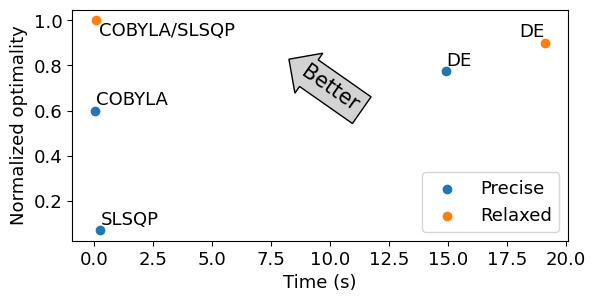

In [5]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 13})
from adjustText import adjust_text

labels = []
xs = []
ys = []

plt.figure(figsize=(6.4, 3))

for k, (times, objs) in parsed_results.items():
    if "step" not in k:
        continue
    labels.append(k)
    xs.append(np.max(times))
    ys.append(-np.max(objs)/10)

plt.scatter(xs, ys, label="Precise")

texts = []

for i, label in enumerate(labels):
    texts.append(plt.text(xs[i], ys[i], label.replace("_step", "").upper()))
    # plt.annotate(label, (xs[i], ys[i]))

labels = []
xs = []
ys = []

for k, (times, objs) in parsed_results.items():
    if "step" in k:
        continue
    # if k == "slsqp":
    #     continue
    if k == "cobyla":
        continue
    labels.append(k)
    xs.append(np.max(times))
    ys.append(-np.max(objs)/10)

plt.scatter(xs, ys, label="Relaxed")
plt.xlabel("Time (s)")
plt.ylabel("Normalized optimality")
plt.legend(loc='lower right')

for i, label in enumerate(labels):
    if label in ["cobyla", "slsqp"]:
        label = "COBYLA/SLSQP"
    texts.append(plt.text(xs[i], ys[i], label.replace("_step", "").upper()))

bbox_props = dict(boxstyle="larrow", fc="lightgrey", ec=None, alpha=1, lw=1)
t = plt.text(10, 0.7, "Better", ha="center", va="center", rotation=-35,
            size=15,
            bbox=bbox_props)

adjust_text(texts)
plt.savefig("images/optim_time_quality.eps", bbox_inches='tight')